In [121]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [122]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
# folder dataset
happy_cat_folder = "dataset/happy_cat/"
angry_cat_folder = "dataset/angry_cat/"
sad_cat_folder = "dataset/sad_cat/"
neutral_cat_folder = "dataset/neutral_cat/"

happy_dog_folder = "dataset/happy_dog/"
angry_dog_folder = "dataset/angry_dog/"
sad_dog_folder = "dataset/sad_dog/"
neutral_dog_folder = "dataset/neutral_dog/"

limit = 125

In [125]:
# Function to load images and keep track of file names
def load_images_with_filenames(folder, file_extension, limit=None):
    files = glob.glob(folder + file_extension)
    if limit:
        files = files[:limit]
    return [(file, cv2.imread(file)) for file in files]

# Load images and filenames
happy_cat_images = load_images_with_filenames(happy_cat_folder, "*.jpg", limit)
happy_cat_images += load_images_with_filenames(happy_cat_folder, "*.jpeg", limit)

sad_cat_images = load_images_with_filenames(sad_cat_folder, "*.jpg", limit)
sad_cat_images += load_images_with_filenames(sad_cat_folder, "*.jpeg", limit)

angry_cat_images = load_images_with_filenames(angry_cat_folder, "*.jpg", limit)
angry_cat_images += load_images_with_filenames(angry_cat_folder, "*.jpeg", limit)

neutral_cat_images = load_images_with_filenames(neutral_cat_folder, "*.jpg", limit)
neutral_cat_images += load_images_with_filenames(neutral_cat_folder, "*.jpeg", limit)


happy_dog_images = load_images_with_filenames(happy_dog_folder, "*.jpg", limit)
happy_dog_images += load_images_with_filenames(happy_dog_folder, "*.jpeg", limit)

sad_dog_images = load_images_with_filenames(sad_dog_folder, "*.jpg", limit)
sad_dog_images += load_images_with_filenames(sad_dog_folder, "*.jpeg", limit)

angry_dog_images = load_images_with_filenames(angry_dog_folder, "*.jpg", limit)
angry_dog_images += load_images_with_filenames(angry_dog_folder, "*.jpeg", limit)

neutral_dog_images = load_images_with_filenames(neutral_dog_folder, "*.jpg", limit)
neutral_dog_images += load_images_with_filenames(neutral_dog_folder, "*.jpeg", limit)


# Define the images size
common_size = (224, 224)

def resize_images(image_list):
    resized_images = []
    for file_name, image in image_list:
        if image is not None:
            resized_images.append(cv2.resize(image, common_size))
        else:
            print(f"Failed to load image: {file_name}")
    return resized_images

# Resize images and print filenames of None images
images_happy_cat = resize_images(happy_cat_images)
images_sad_cat = resize_images(sad_cat_images)
images_angry_cat = resize_images(angry_cat_images)
images_neutral_cat = resize_images(neutral_cat_images)

images_happy_dog = resize_images(happy_dog_images)
images_sad_dog = resize_images(sad_dog_images)
images_angry_dog = resize_images(angry_dog_images)
images_neutral_dog = resize_images(neutral_dog_images)

libpng warning: iCCP: known incorrect sRGB profile


In [126]:
# # Use glob to get both .jpg and .jpeg files
# happy_files = glob.glob(happy_folder + "*.jpg") + glob.glob(happy_folder + "*.jpeg")
# angry_files = glob.glob(angry_folder + "*.jpg") + glob.glob(angry_folder + "*.jpeg")
# sad_files = glob.glob(sad_folder + "*.jpg") + glob.glob(sad_folder + "*.jpeg")
# neutral_files = glob.glob(neutral_folder + "*.jpg") + glob.glob(neutral_folder + "*.jpeg")

In [ ]:
# # Now read the images using cv2.imread
# images_happy = [cv2.imread(file) for file in happy_files][:limit]
# images_angry = [cv2.imread(file) for file in angry_files][:limit]
# images_sad = [cv2.imread(file) for file in sad_files][:limit]
# images_neutral = [cv2.imread(file) for file in neutral_files][:limit]

In [127]:
# images labeling
labels_neutral_cat = [0] * len(images_neutral_cat)
labels_happy_cat = [1] * len(images_happy_cat)
labels_angry_cat = [2] * len(images_angry_cat)
labels_sad_cat = [3] * len(images_sad_cat)

labels_neutral_dog = [0] * len(images_neutral_dog)
labels_happy_dog = [1] * len(images_happy_dog)
labels_angry_dog = [2] * len(images_angry_dog)
labels_sad_dog = [3] * len(images_sad_dog)

In [128]:
# checking data
happy_cat_count = len(images_happy_cat)
angry_cat_count = len(images_angry_cat)
sad_cat_count = len(images_sad_cat)
neutral_cat_count = len(images_neutral_cat)

happy_dog_count = len(images_happy_dog)
angry_dog_count = len(images_angry_dog)
sad_dog_count = len(images_sad_dog)
neutral_dog_count = len(images_neutral_dog)


print(f"happy cat files : {happy_cat_count}")
print(f"angry cat files : {angry_cat_count}")
print(f"sad cat files : {sad_cat_count}")
print(f"neutral cat files : {neutral_cat_count}")

print(f"happy dog files : {happy_dog_count}")
print(f"angry dog files : {angry_dog_count}")
print(f"sad dog files : {sad_dog_count}")
print(f"neutral dog files : {neutral_dog_count}")

happy cat files : 125
angry cat files : 125
sad cat files : 125
neutral cat files : 125
happy dog files : 125
angry dog files : 125
sad dog files : 125
neutral dog files : 125


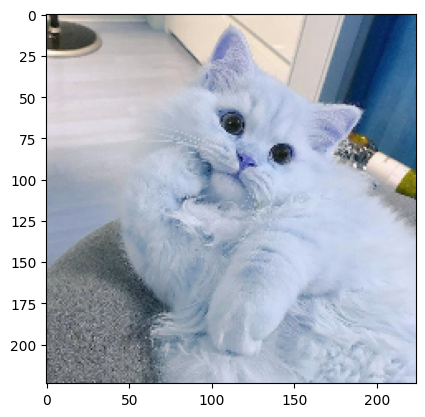

In [129]:
img = np.asarray(images_happy_cat[123])
imgplot = plt.imshow(img)

In [ ]:
# # resize images to 112x112

# common_size = (112,112)
# images_happy = [cv2.resize(image, common_size) for image in images_happy]
# images_angry = [cv2.resize(image, common_size) for image in images_angry]
# images_sad = [cv2.resize(image, common_size) for image in images_sad]
# images_neutral = [cv2.resize(image, common_size) for image in images_neutral]

In [130]:
# Concatenate images and labels
X = np.concatenate((images_neutral_cat, images_happy_cat, images_angry_cat, images_sad_cat, 
                    images_neutral_dog, images_happy_dog, images_angry_dog, images_sad_dog), axis = 0)

y = np.concatenate((labels_neutral_cat, labels_happy_cat, labels_angry_cat, labels_sad_cat, 
                    labels_neutral_dog, labels_happy_dog, labels_angry_dog, labels_sad_dog), axis = 0)

In [131]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [132]:
X_train.shape

(800, 224, 224, 3)

In [133]:
y_train.shape

(800,)

# VCG16 Model

In [134]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16

In [135]:
def initialize_vgg16_model():
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

    # Add the pre-trained VGG16 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [136]:
model_vgg16 = initialize_vgg16_model()

In [137]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_vgg16.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 93s 5s/step - loss: 86.4534 - accuracy: 0.3875 - val_loss: 34.5765 - val_accuracy: 0.5375
Epoch 2/25
20/20 [==============================] - 93s 5s/step - loss: 14.8559 - accuracy: 0.7391 - val_loss: 22.2656 - val_accuracy: 0.5562
Epoch 3/25
20/20 [==============================] - 91s 5s/step - loss: 3.8163 - accuracy: 0.9141 - val_loss: 25.3046 - val_accuracy: 0.5500
Epoch 4/25
20/20 [==============================] - 93s 5s/step - loss: 1.6203 - accuracy: 0.9516 - val_loss: 21.1690 - val_accuracy: 0.5938
Epoch 5/25
20/20 [==============================] - 116s 6s/step - loss: 0.6697 - accuracy: 0.9672 - val_loss: 21.4378 - val_accuracy: 0.5250
Epoch 6/25
20/20 [==============================] - 106s 5s/step - loss: 0.2225 - accuracy: 0.9828 - val_loss: 21.1593 - val_accuracy: 0.5625
Epoch 7/25
20/20 [==============================] - 102s 5s/step - loss: 0.3663 - accuracy: 0.9750 - val_loss: 21.3039 - val_accuracy: 0.5688
Epoch 8/

In [138]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # ----Loss----
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Validation'], loc= 'best')
    ax[0].grid(axis='x', linewidth=0.5)
    ax[0].grid(axis='y', linewidth=0.5)
    
    # ----Accuracy----
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['Train', 'Validation'], loc= 'best')
    ax[1].grid(axis='x', linewidth=0.5)
    ax[1].grid(axis='y', linewidth=0.5)
    
    if title:
        fig.suptitle(title)

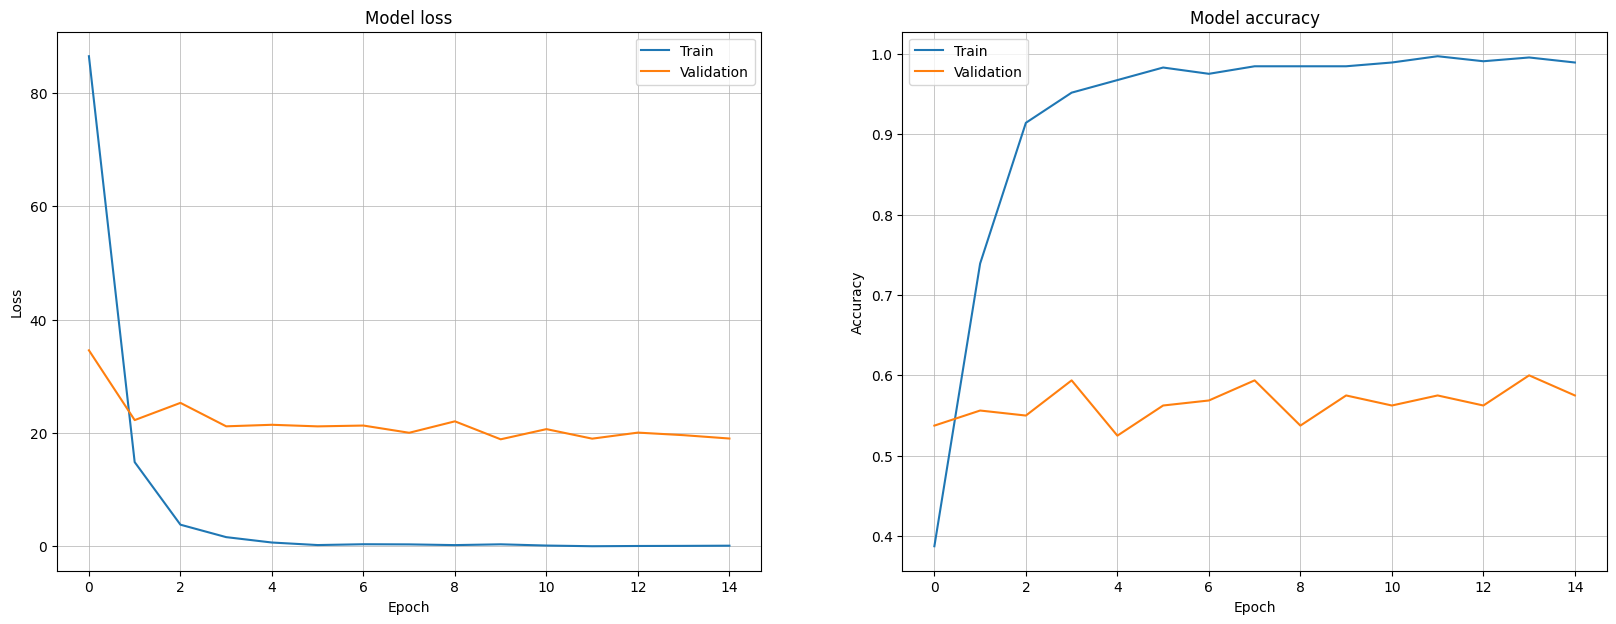

In [139]:
plot_loss_accuracy(history, title=None)

In [140]:
evaluation = model_vgg16.evaluate(X_test, y_test)

7/7 [==============================] - 24s 3s/step - loss: 17.9342 - accuracy: 0.6150


In [141]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 61.5 %


# VCG19 Model

In [142]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg19

In [143]:
def initialize_vgg19_model():
    # Load the pre-trained VGG19 model without the top (fully connected) layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained VGG19 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

    # Add the pre-trained VGG19 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [144]:
model_vgg19 = initialize_vgg19_model()

In [145]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_vgg19.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 106s 5s/step - loss: 67.3915 - accuracy: 0.3781 - val_loss: 48.0645 - val_accuracy: 0.5000
Epoch 2/25
20/20 [==============================] - 111s 6s/step - loss: 12.1545 - accuracy: 0.8031 - val_loss: 36.0042 - val_accuracy: 0.5250
Epoch 3/25
20/20 [==============================] - 114s 6s/step - loss: 3.9306 - accuracy: 0.9125 - val_loss: 29.5381 - val_accuracy: 0.5500
Epoch 4/25
20/20 [==============================] - 116s 6s/step - loss: 2.1008 - accuracy: 0.9375 - val_loss: 32.6412 - val_accuracy: 0.5625
Epoch 5/25
20/20 [==============================] - 116s 6s/step - loss: 0.6584 - accuracy: 0.9656 - val_loss: 33.1649 - val_accuracy: 0.5500
Epoch 6/25
20/20 [==============================] - 116s 6s/step - loss: 0.5843 - accuracy: 0.9797 - val_loss: 31.6011 - val_accuracy: 0.5875
Epoch 7/25
20/20 [==============================] - 118s 6s/step - loss: 0.3133 - accuracy: 0.9875 - val_loss: 29.0528 - val_accuracy: 0.5562
Epoc

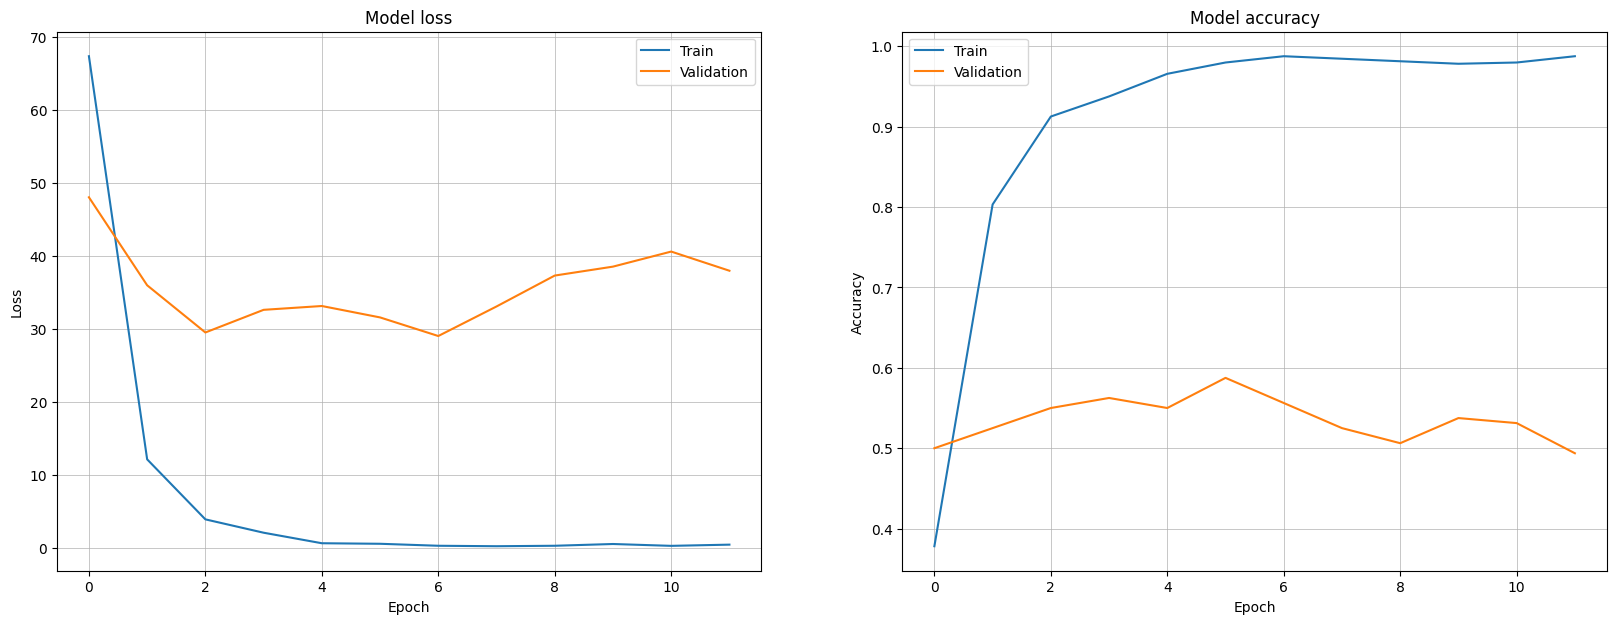

In [146]:
plot_loss_accuracy(history, title=None)

In [147]:
evaluation = model_vgg19.evaluate(X_test, y_test)

7/7 [==============================] - 30s 4s/step - loss: 23.0809 - accuracy: 0.6350


In [148]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 63.5 %


# EfficientNetB3

In [149]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.applications import EfficientNetB0

In [150]:
def initialize_effnetB0_model():
    # Load the pre-trained EfficientNetB0 model without the top (fully connected) layers
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained EfficientNetB0 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()


    # Add the pre-trained EfficientNetB0 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [151]:
model_effnet = initialize_effnetB0_model()

In [152]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_effnet.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 13s 539ms/step - loss: 9.7046 - accuracy: 0.4047 - val_loss: 5.2407 - val_accuracy: 0.5688
Epoch 2/25
20/20 [==============================] - 10s 517ms/step - loss: 1.3821 - accuracy: 0.7969 - val_loss: 4.5293 - val_accuracy: 0.5688
Epoch 3/25
20/20 [==============================] - 10s 503ms/step - loss: 0.3805 - accuracy: 0.9203 - val_loss: 3.3600 - val_accuracy: 0.5813
Epoch 4/25
20/20 [==============================] - 10s 507ms/step - loss: 0.1081 - accuracy: 0.9734 - val_loss: 3.0778 - val_accuracy: 0.5688
Epoch 5/25
20/20 [==============================] - 10s 506ms/step - loss: 0.0671 - accuracy: 0.9797 - val_loss: 3.0985 - val_accuracy: 0.6000
Epoch 6/25
20/20 [==============================] - 10s 503ms/step - loss: 0.0551 - accuracy: 0.9797 - val_loss: 3.1055 - val_accuracy: 0.6062
Epoch 7/25
20/20 [==============================] - 10s 513ms/step - loss: 0.0232 - accuracy: 0.9891 - val_loss: 3.4986 - val_accuracy: 0.5938

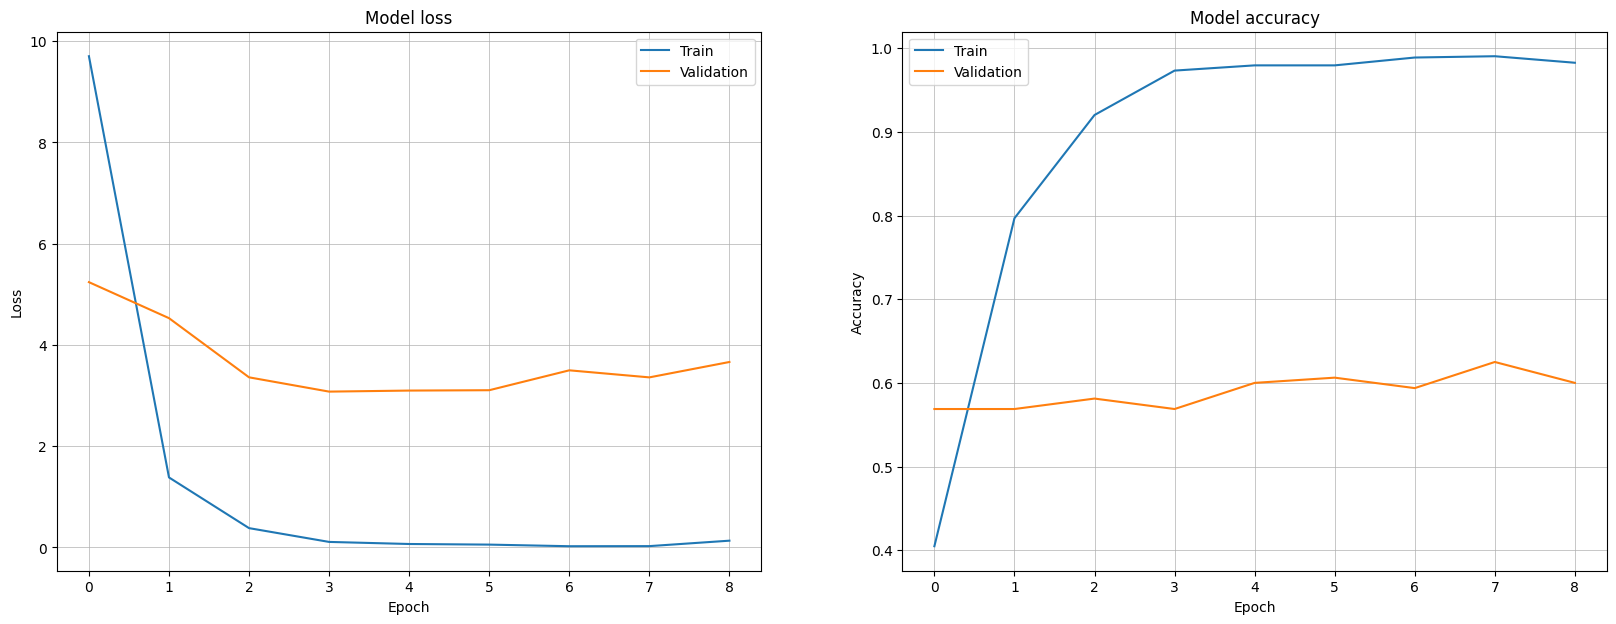

In [153]:
plot_loss_accuracy(history, title=None)

In [154]:
evaluation = model_effnet.evaluate(X_test, y_test)

7/7 [==============================] - 3s 316ms/step - loss: 2.4686 - accuracy: 0.6650


In [155]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 66.5 %


# Inception

In [43]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [44]:
def initialize_inception_model():
    model = Sequential()

    model.add(base_model)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer = 'adam', 
                  loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model

In [45]:
model_inception = initialize_inception_model()

In [46]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_inception.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 18s 860ms/step - loss: 724.5668 - accuracy: 0.2703 - val_loss: 317.8500 - val_accuracy: 0.2937
Epoch 2/25
20/20 [==============================] - 17s 858ms/step - loss: 284.2527 - accuracy: 0.3875 - val_loss: 283.9651 - val_accuracy: 0.3125
Epoch 3/25
20/20 [==============================] - 20s 1s/step - loss: 137.2135 - accuracy: 0.4766 - val_loss: 133.7632 - val_accuracy: 0.3063
Epoch 4/25
20/20 [==============================] - 19s 978ms/step - loss: 61.3504 - accuracy: 0.5500 - val_loss: 64.2471 - val_accuracy: 0.3000
Epoch 5/25
20/20 [==============================] - 19s 942ms/step - loss: 25.0357 - accuracy: 0.5375 - val_loss: 20.4583 - val_accuracy: 0.2812
Epoch 6/25
20/20 [==============================] - 18s 923ms/step - loss: 4.6560 - accuracy: 0.5391 - val_loss: 3.8415 - val_accuracy: 0.3125
Epoch 7/25
20/20 [==============================] - 18s 897ms/step - loss: 1.2293 - accuracy: 0.6391 - val_loss: 3.2064 - val_acc

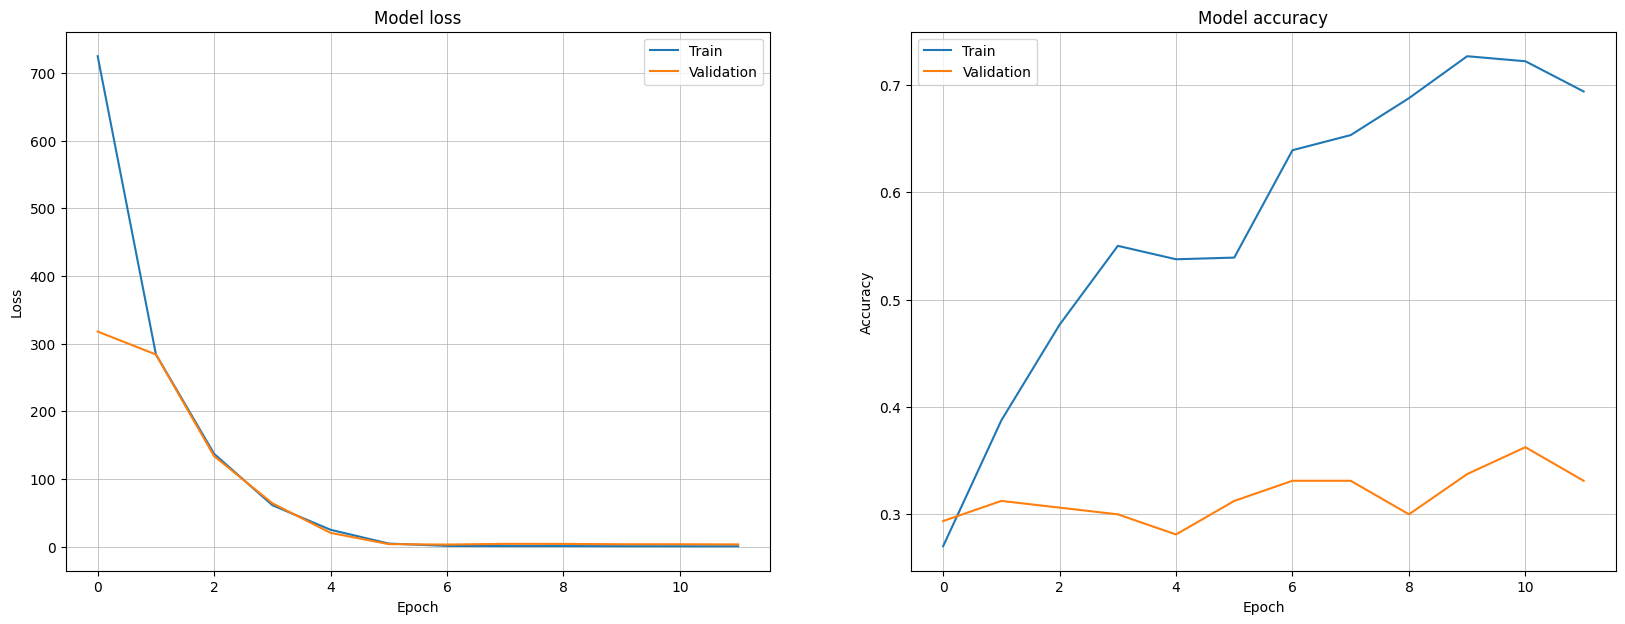

In [47]:
plot_loss_accuracy(history, title=None)

In [48]:
evaluation = model_inception.evaluate(X_test, y_test)

7/7 [==============================] - 6s 621ms/step - loss: 3.5247 - accuracy: 0.3100


In [49]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 31.0 %


# Resnet

In [86]:
from tensorflow.keras.applications import ResNet50

model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")


for layer in model.layers:
    layer.trainable = False

In [87]:
def initialize_resnet():

    model = Sequential()
    model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer = 'adam', 
                       loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [88]:
model_resnet = initialize_resnet()

In [89]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model_resnet.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 99s 5s/step - loss: 8.6904 - accuracy: 0.3375 - val_loss: 3913.1665 - val_accuracy: 0.2438
Epoch 2/25
20/20 [==============================] - 104s 5s/step - loss: 6.6639 - accuracy: 0.3812 - val_loss: 13016841.0000 - val_accuracy: 0.2562
Epoch 3/25
20/20 [==============================] - 107s 5s/step - loss: 2.3337 - accuracy: 0.5797 - val_loss: 1005159.0000 - val_accuracy: 0.2750
Epoch 4/25
20/20 [==============================] - 112s 6s/step - loss: 1.1687 - accuracy: 0.7641 - val_loss: 24843.4648 - val_accuracy: 0.2562
Epoch 5/25
20/20 [==============================] - 92s 5s/step - loss: 0.5905 - accuracy: 0.8594 - val_loss: 965.2964 - val_accuracy: 0.2313
Epoch 6/25
20/20 [==============================] - 105s 5s/step - loss: 0.3319 - accuracy: 0.9375 - val_loss: 35.2143 - val_accuracy: 0.3187
Epoch 7/25
20/20 [==============================] - 124s 6s/step - loss: 0.2642 - accuracy: 0.9375 - val_loss: 44.7232 - val_accuracy

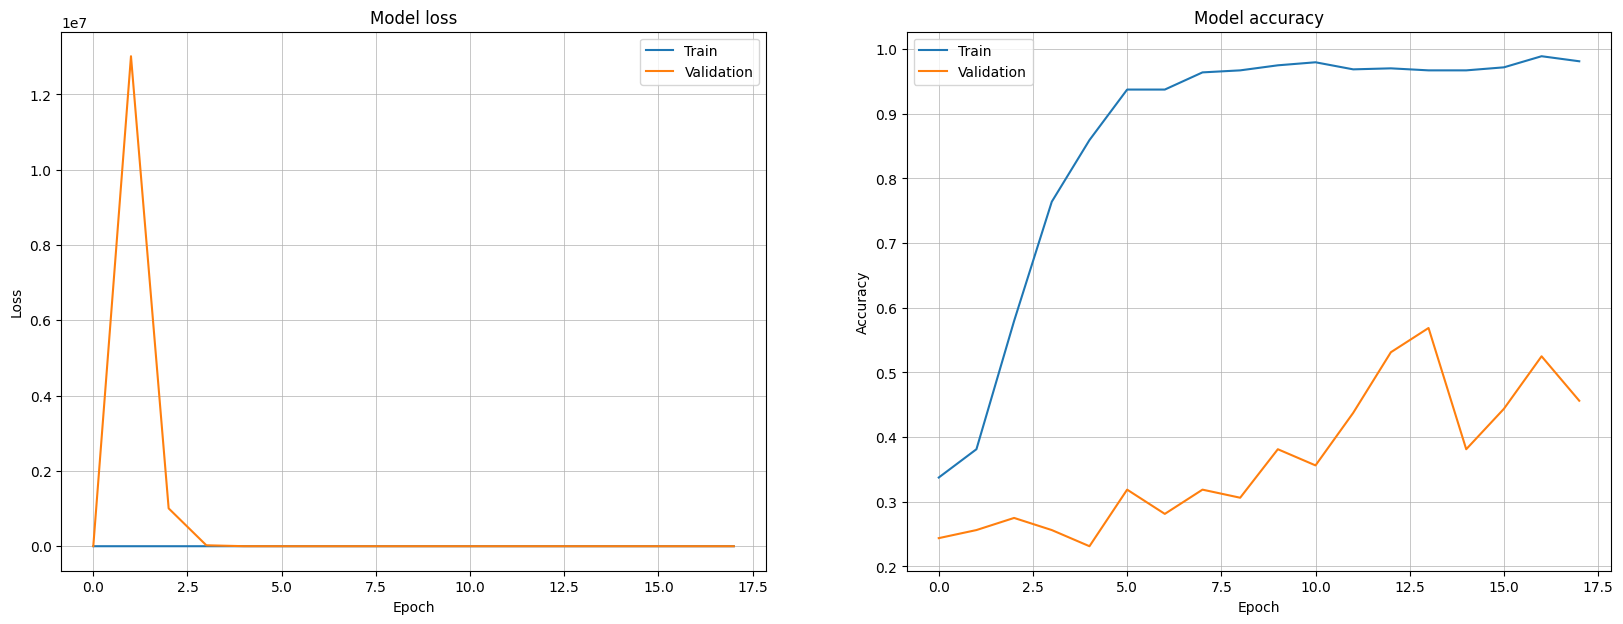

In [90]:
plot_loss_accuracy(history, title=None)

In [91]:
evaluation = model_resnet.evaluate(X_test, y_test)

7/7 [==============================] - 6s 814ms/step - loss: 1.9619 - accuracy: 0.5550


In [92]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 55.5 %


In [159]:
# Save model
model_effnet.save("pets_expression_effnet_635_8class", save_format='tf')

INFO:tensorflow:Assets written to: pets_expression_effnet_635_8class/assets


INFO:tensorflow:Assets written to: pets_expression_effnet_635_8class/assets


In [160]:
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [161]:
# Replace 'path_to_your_image' with the path to your animal image
img_array = load_and_preprocess_image('dataset/cat_test/pixabay_cat_004418.jpg')

In [162]:
# Make a prediction
prediction = model_effnet.predict(img_array)

1/1 [==============================] - 1s 592ms/step


In [163]:
# Decode the prediction
emotion = np.argmax(prediction)
emotions = ['Neutral', 'Happy', 'Angry', 'Sad', 'Neutral', 'Happy', 'Angry', 'Sad']
predicted_emotion = emotions[emotion]

print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: Sad
